## FEATURIZATION OF TEXT:-

We would follow two approaches to featurize text:-

1) Count Vectorizer (Only Unigrams)

2) Tfidf Vectorizer

## MODELLING:-

We would fit the following 5 models on the given text data and would choose the best one:-

1) Naive Bayes

2) Logistic Regression

3) Linear SVM

4) GBDT

5) Random Forest

For each of the above models, we would do hyperparameter tuning.

### IMPORTING THE PREPROCESSED DATA

In [1]:
# Importing the libraries

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import GradientBoostingClassifier as gbc
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from scipy.sparse import hstack

In [2]:
# Importing the preprocessed_data

preprocessed_data = pd.read_csv("preprocessed_data.csv")

preprocessed_data.head()

,textID,preprocessed_text,Length_of_Preprocessed_Text,class
0,2a0463352b,enough nothing hours,3,0
1,f358968122,clothes shopping tomorrow hate serious clothes...,9,1
2,449e7733f1,bored idea nice site,4,0
3,6099baf6e8,not think want come back guys read dms,8,1
4,f946da7a04,thomas drinking game tonight not work till tom...,8,0


### CHECKING FOR EMPTY ROWS AND REMOVING THEM

In [3]:
preprocessed_data.fillna('', inplace=True)

# Checking for no preprocessed text
def check_no_preprocessed_text(df):
    return [i for i in range(len(df)) if len(str(df.iloc[i,1]).split())==0]

# Calling the function check_no_preprocessed_text to check the index which has no text

list_of_indices = check_no_preprocessed_text(preprocessed_data)

list_of_indices

[5972, 9104]

In [4]:
# Dropping the rows which has no text

preprocessed_data = preprocessed_data.drop(labels = list_of_indices, axis = 0)

preprocessed_data.shape

(18406, 4)

### CHECKING AND REMOVING DUPLICATE PREPROCESSED TEXT

In [5]:
# Checking whether there are two same texts in the data

duplicate_text = preprocessed_data[preprocessed_data.duplicated(subset = ['preprocessed_text','class'])]

duplicate_text

,textID,preprocessed_text,Length_of_Preprocessed_Text,class


### SPLITTING OF DATA INTO TRAINING AND CV DATA

In [6]:
X = preprocessed_data[['preprocessed_text','Length_of_Preprocessed_Text']]
Y = preprocessed_data['class']

In [7]:
# Importing the library

X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size = 0.25, stratify = Y, random_state = 42)

### TEXT FEATURIZATION

#### BAG OF WORDS (BOW)

In [8]:
# Countvectorizer or Bag of Words on unigrams

countvec = CountVectorizer(min_df=10, ngram_range = (1,1))
preprocessed_train_bow = countvec.fit_transform(X_train.preprocessed_text.values)
print("Shape of the training data after fitting Countvectorizer ",preprocessed_train_bow.shape)

Shape of the training data after fitting Countvectorizer  (13804, 1366)


In [9]:
# Transforming the test data also

preprocessed_te_bow = countvec.transform(X_test.preprocessed_text.values)

print("Shape of the test data after fitting Countvectorizer ",preprocessed_te_bow.shape)

Shape of the test data after fitting Countvectorizer  (4602, 1366)


#### TFIDF

In [10]:
# Countvectorizer or Bag of Words on unigrams

tfidfvec = TfidfVectorizer(min_df=10, ngram_range = (1,1))
preprocessed_train_tfidf = tfidfvec.fit_transform(X_train.preprocessed_text.values)
print("Shape of the training data after fitting Tfidfvectorizer ",preprocessed_train_tfidf.shape)

Shape of the training data after fitting Tfidfvectorizer  (13804, 1366)


In [11]:
# Transforming the test data also

#preprocessed_cv_tfidf = tfidfvec.transform(X_CV)
preprocessed_te_tfidf = tfidfvec.transform(X_test.preprocessed_text.values)

print("Shape of the test data after fitting Tfidfvectorizer ",preprocessed_te_tfidf.shape)

Shape of the test data after fitting Tfidfvectorizer  (4602, 1366)


### SCALING OF THE NUMERICAL FEATURE

In [12]:
minmax = MinMaxScaler()

prep_length_tr = minmax.fit_transform(X_train.Length_of_Preprocessed_Text.values.reshape(-1,1))
prep_length_te = minmax.transform(X_test.Length_of_Preprocessed_Text.values.reshape(-1,1))

### FINAL FEATURE MATRIX

In [13]:
preprocessed_train_bow = hstack((preprocessed_train_bow,prep_length_tr))
preprocessed_te_bow = hstack((preprocessed_te_bow,prep_length_te))
preprocessed_train_tfidf = hstack((preprocessed_train_tfidf,prep_length_tr))
preprocessed_te_tfidf = hstack((preprocessed_te_tfidf,prep_length_te))

### FUNCTION TO DRAW THE CONFUSION MATRIX ALONG WITH PRECISION AND RECALL MATRIX

In [20]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    print("Number of misclassified points ",(len(test_y)-np.trace(C))/len(test_y)*100)
    # C = 2,2 matrix, each cell (i,j) represents number of points of class i are predicted class j
    # The predictions are along the columns of the confusion matrix whereas the actual values are along the rows of confusion matrix.
    
    A =(((C.T)/(C.sum(axis=1))).T)
        
    B =(C/C.sum(axis=0))
        
    labels = [0,1]
    cmap=sns.light_palette("green")
    # representing A in heatmap format
    #print("-"*50, "Confusion matrix", "-"*50)
    plt.figure(figsize=(20,4))
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    #plt.show()

    #print("-"*50, "Precision matrix", "-"*50)
    #plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    #plt.show()
    #print("Sum of columns in precision matrix",B.sum(axis=0))
    
    # representing B in heatmap format
    #print("-"*50, "Recall matrix"    , "-"*50)
    #plt.figure(figsize=(10,5))
    plt.subplot(1, 3, 3)
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    #plt.show()
    #print("Sum of rows in Recall matrix",A.sum(axis=1))

### NAIVE BAYES

#### HYPERPARAMETER TUNING

1) Hyperparameter tuning would be based on the parameter alpha which is additive or Laplace Smoothing parameter that prevents posteriors for unseen data points to become zero.

2) The best hyperparameter would be choosen for the highest Recall.

#### BOW(Bag of Words) OR COUNTVECTORIZER

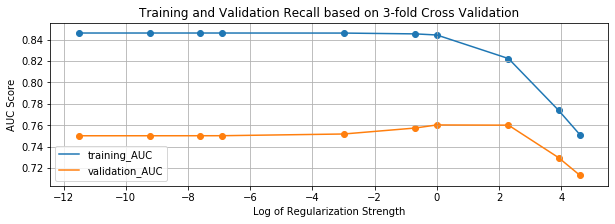

The best regularization strength parameter alpha on the random search over the given hyperparameter space for CountVectorizer is :  {'alpha': 1}


In [15]:
NB = MultinomialNB()
params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(NB, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)


train_recall = results["mean_train_score"]
train_std = results["std_train_score"]
cv_recall = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_recall, label = "training_AUC")
plt.plot(hparam, cv_recall, label = "validation_AUC")
plt.scatter(hparam, train_recall)
plt.scatter(hparam, cv_recall)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation Recall based on 3-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search over the given hyperparameter space for CountVectorizer is : ", clf.best_params_)

#### TFIDF Vectorizer

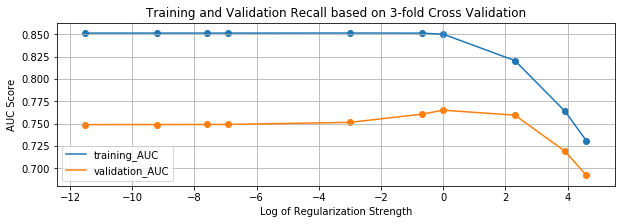

The best regularization strength parameter alpha on the random search over the given hyperparameter space for TFIDF Vectorizer is :  {'alpha': 1}


In [16]:
NB = MultinomialNB()
params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(NB, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)


train_recall = results["mean_train_score"]
train_std = results["std_train_score"]
cv_recall = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_recall, label = "training_AUC")
plt.plot(hparam, cv_recall, label = "validation_AUC")
plt.scatter(hparam, train_recall)
plt.scatter(hparam, cv_recall)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation Recall based on 3-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search over the given hyperparameter space for TFIDF Vectorizer is : ", clf.best_params_)

#### FUNCTION TO CALCULATE BEST THRESHOLD AND PREDICT WITH THE SAME

In [17]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr(recall) is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

#### BEST MODEL FITTING

#### BAG OF WORDS OR COUNTVECTORIZER

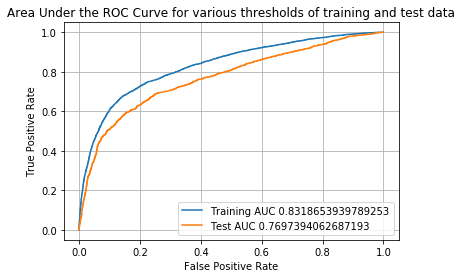

In [18]:
best_alpha = 1

# Fitting the multinomial naive bayes algorithm
best_mod = MultinomialNB(alpha = best_alpha)

best_mod.fit(preprocessed_train_bow, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_NB_bow = best_alpha

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.5816609104620617 for threshold 0.438
Number of misclassified points  27.444589308996086


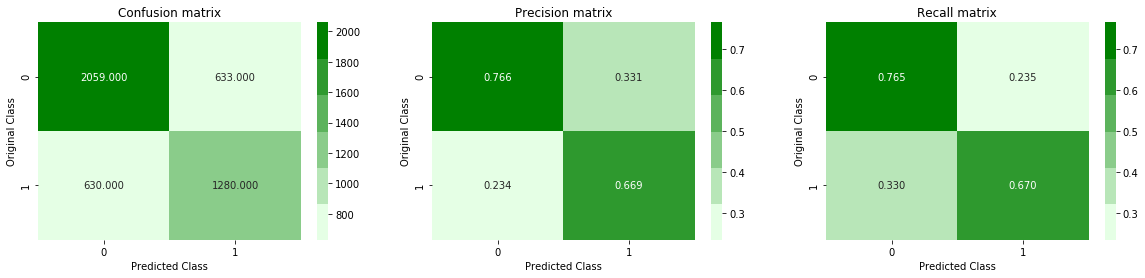

In [21]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_NB_bow = best_t

#### TFIDF VECTORIZER

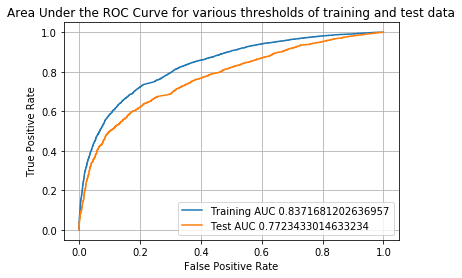

In [22]:
best_alpha = 1

# Fitting the multinomial naive bayes algorithm
best_mod = MultinomialNB(alpha = best_alpha)

best_mod.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_NB_tfidf = best_alpha

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.5797929279473776 for threshold 0.415
Number of misclassified points  28.639721860060842


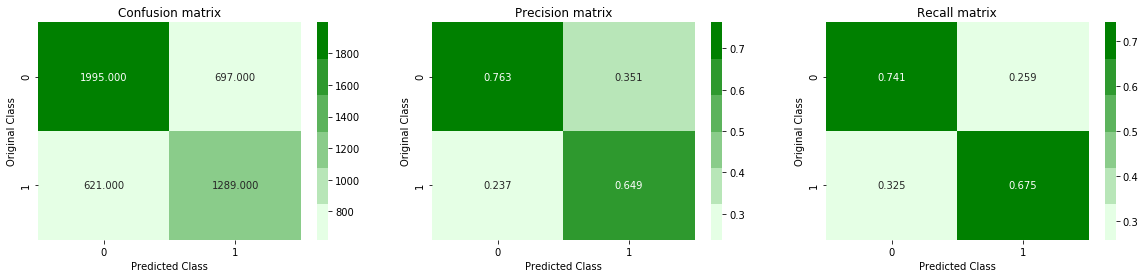

In [23]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_NB_tfidf = best_t

### LOGISTIC REGRESSION

#### HYPERPARAMETER TUNING

1) Alpha which is directly proportional to regularization.

2) Penalty which could L1, L2 or Elastic Net

#### BAG OF WORDS (BOW) OR COUNTVECTORIZER

The best set of parameters for the LR Classifier on the BOW featurized data are : {'penalty': 'L2', 'alpha': 0.0005}


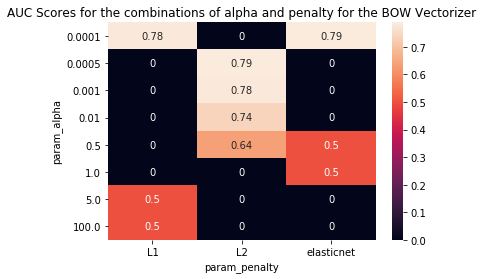

In [24]:
LR = SGDClassifier(loss = 'log')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100], 'penalty':['L1','L2','elasticnet']}

clf = RandomizedSearchCV(LR, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_alpha","param_penalty"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
#hparam_alpha = pd.Series([np.log(x) for x in results.param_alpha.values])
#hparam_penalty = results.param_penalty.values

score_df = pd.pivot_table(data = results, index = "param_alpha", columns = "param_penalty", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of alpha and penalty for the BOW Vectorizer")

print("The best set of parameters for the LR Classifier on the BOW featurized data are : {}".format(clf.best_params_))

#### TFIDF VECTORIZER

The best set of parameters for the LR Classifier on the TFIDF featurized data are : {'penalty': 'L1', 'alpha': 0.0001}


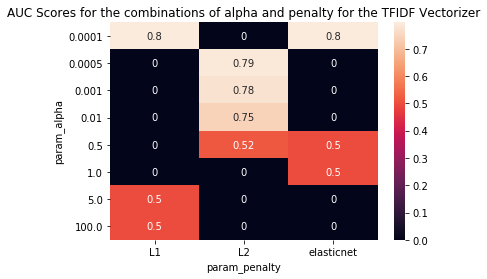

In [25]:
LR = SGDClassifier(loss = 'log')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100], 'penalty':['L1','L2','elasticnet']}

clf = RandomizedSearchCV(LR, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_alpha","param_penalty"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
#hparam_alpha = pd.Series([np.log(x) for x in results.param_alpha.values])
#hparam_penalty = results.param_penalty.values

score_df = pd.pivot_table(data = results, index = "param_alpha", columns = "param_penalty", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of alpha and penalty for the TFIDF Vectorizer")

print("The best set of parameters for the LR Classifier on the TFIDF featurized data are : {}".format(clf.best_params_))

#### BEST MODEL FITTING

#### COUNTVECTORIZER OR BAG OF WORDS (BOW)

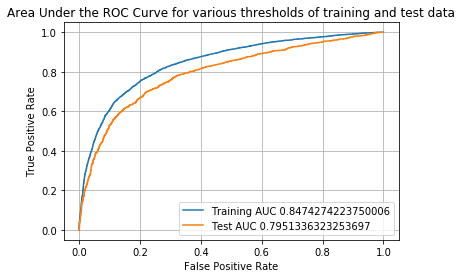

In [26]:
best_alpha = 0.0005
best_penalty = 'L2'

# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(alpha = best_alpha, penalty = best_penalty, loss = 'log')

best_mod.fit(preprocessed_train_bow, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_LR_bow = best_alpha
best_penalty_LR_bow = best_penalty

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.6027685767971004 for threshold 0.381
Number of misclassified points  25.771403737505434


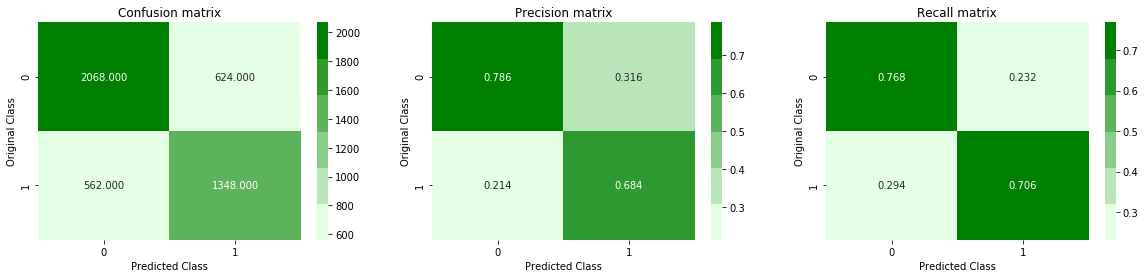

In [27]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_LR_bow = best_t

#### TFIDF VECTORIZER

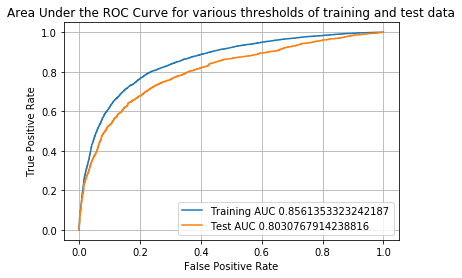

In [28]:
best_alpha = 0.0001
best_penalty = 'elasticnet'

# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(alpha = best_alpha, penalty = best_penalty, loss = 'log')

best_mod.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_LR_tfidf = best_alpha
best_penalty_LR_tfidf = best_penalty

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.6140436116936968 for threshold 0.373
Number of misclassified points  25.88005215123859


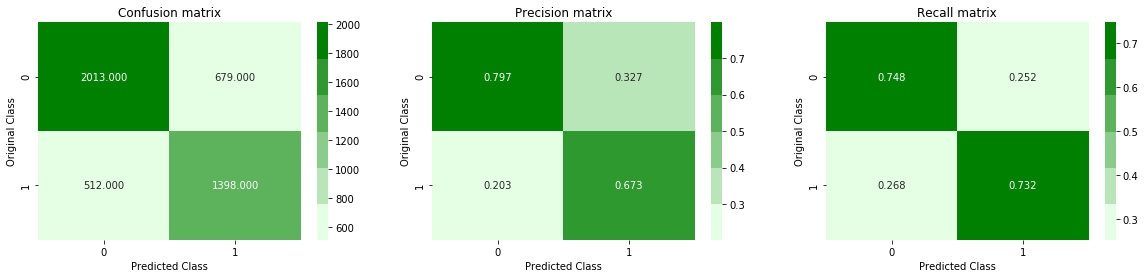

In [29]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_LR_tfidf = best_t

### LINEAR SVM

#### HYPERPARAMETER TUNING

1) C which is the inverse of the regularization strength and it penalizes the outliers.

#### BAG OF WORDS (COUNT VECTORIZER)

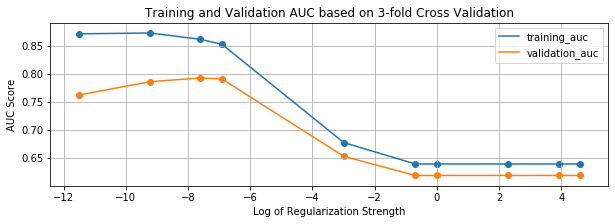

The best regularization strength parameter alpha on the random search over the given hyperparameter space for CountVectorizer using Linear SVM is :  {'alpha': 0.0005}


In [30]:
SV = SGDClassifier(loss = 'hinge')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(SV, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)

train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_auc, label = "training_auc")
plt.plot(hparam, cv_auc, label = "validation_auc")
plt.scatter(hparam, train_auc)
plt.scatter(hparam, cv_auc)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation AUC based on 3-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search over the given hyperparameter space for CountVectorizer using Linear SVM is : ", clf.best_params_)

#### TFIDF VECTORIZER

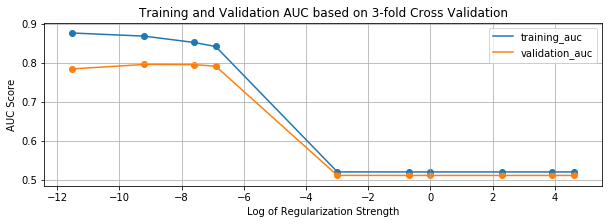

The best regularization strength parameter alpha on the random search over the given hyperparameter space for TFIDF Vectorizer using Linear SVM is :  {'alpha': 0.0001}


In [31]:
SV = SGDClassifier(loss = 'hinge')

params = {'alpha': [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}

clf = RandomizedSearchCV(SV, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = "param_alpha", inplace=True)

train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]
hparam = pd.Series([np.log(x) for x in results.param_alpha.values])

plt.figure(figsize = (10,3))
plt.plot(hparam, train_auc, label = "training_auc")
plt.plot(hparam, cv_auc, label = "validation_auc")
plt.scatter(hparam, train_auc)
plt.scatter(hparam, cv_auc)
plt.xlabel("Log of Regularization Strength")
plt.ylabel("AUC Score")
plt.title("Training and Validation AUC based on 3-fold Cross Validation")
plt.legend()
plt.grid()
plt.show()

print("The best regularization strength parameter alpha on the random search over the given hyperparameter space for TFIDF Vectorizer using Linear SVM is : ", clf.best_params_)

#### BEST MODEL FITTING

#### COUNTVECTORIZER OR BAG OF WORDS (BOW)

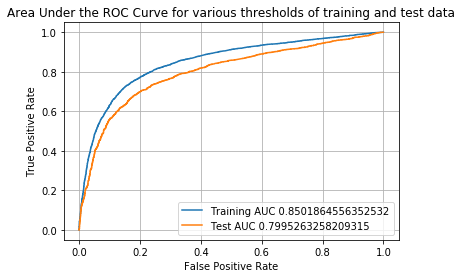

In [32]:
best_alpha = 0.0005

# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(alpha = best_alpha, loss = 'hinge')
cal_clf = CalibratedClassifierCV(best_mod, method = "sigmoid", cv = 3)

cal_clf.fit(preprocessed_train_bow, Y_train)

y_train_pred = cal_clf.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = cal_clf.predict_proba(preprocessed_te_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_SVM_bow = best_alpha

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.6191160393565517 for threshold 0.363
Number of misclassified points  24.923946110386787


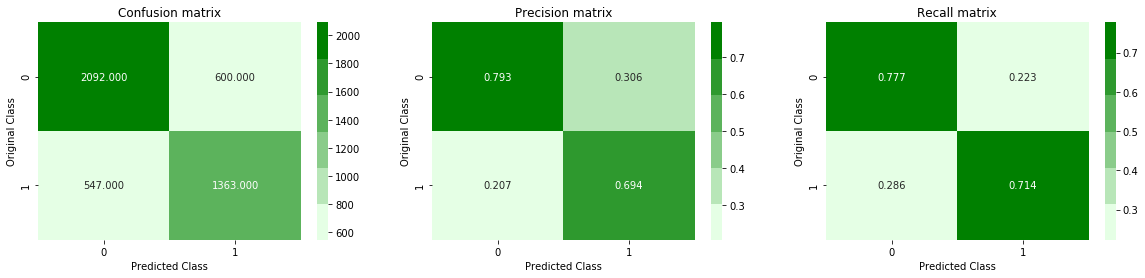

In [33]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_SVM_bow = best_t

#### TFIDF VECTORIZER

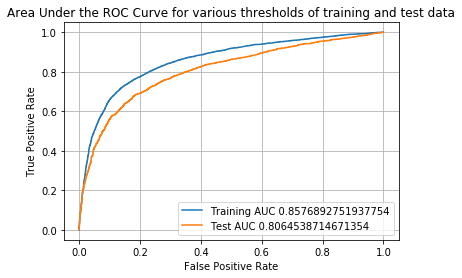

In [34]:
best_alpha = 0.0001

# Fitting the multinomial naive bayes algorithm
best_mod = SGDClassifier(alpha = best_alpha, loss = 'hinge')
cal_clf = CalibratedClassifierCV(best_mod, method = "sigmoid", cv = 3)

cal_clf.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = cal_clf.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = cal_clf.predict_proba(preprocessed_te_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_alpha_SVM_tfidf = best_alpha

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.6245884741527409 for threshold 0.387
Number of misclassified points  25.206431986093


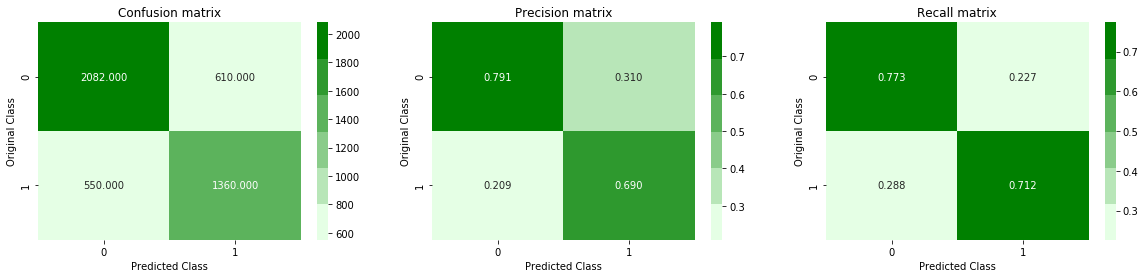

In [35]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_SVM_tfidf = best_t

### GRADIENT BOOSTED DECISION TREES

#### HYPERPARAMETER TUNING

1) No. of Base Learners

2) Learning Rate

#### COUNTVECTORIZER OR BOW (BAG OF WORDS)

The best set of parameters for the GBDT Classifier on the BOW featurized data are : {'n_estimators': 75, 'learning_rate': 0.3}


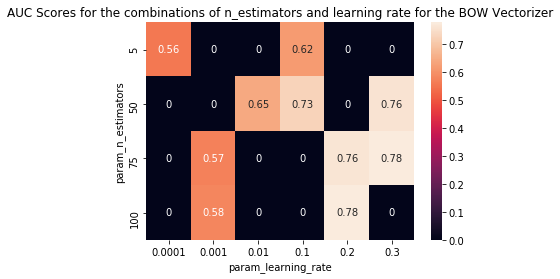

In [36]:
gbdt_clf = gbc()

params = {'n_estimators':[5,10,50,75,100], 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}

clf = RandomizedSearchCV(gbdt_clf, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_learning_rate"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_learning_rate", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and learning rate for the BOW Vectorizer")

print("The best set of parameters for the GBDT Classifier on the BOW featurized data are : {}".format(clf.best_params_))

#### TFIDF VECTORIZER

The best set of parameters for the GBDT Classifier on the TFIDF featurized data are : {'n_estimators': 100, 'learning_rate': 0.2}


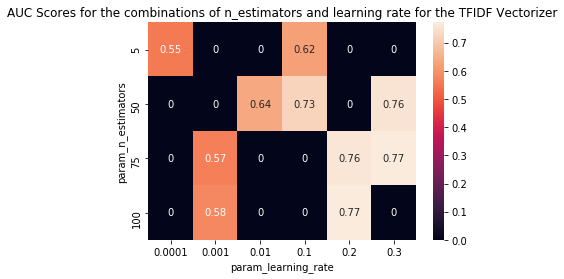

In [37]:
gbdt_clf = gbc()

params = {'n_estimators':[5,10,50,75,100], 'learning_rate':[0.0001,0.001,0.01,0.1,0.2,0.3]}

clf = RandomizedSearchCV(gbdt_clf, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_learning_rate"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_learning_rate", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and learning rate for the TFIDF Vectorizer")

print("The best set of parameters for the GBDT Classifier on the TFIDF featurized data are : {}".format(clf.best_params_))

#### BEST MODEL FITTING

#### COUNTVECTORIZER OR BAG OF WORDS (BOW)

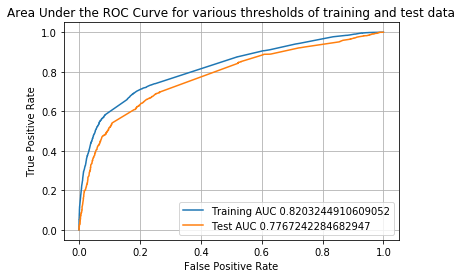

In [38]:
best_n_estimators = 75
best_learning_rate = 0.3

# Fitting the multinomial naive bayes algorithm
best_mod = gbc(n_estimators = best_n_estimators, learning_rate = best_learning_rate)

best_mod.fit(preprocessed_train_bow, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_n_est_gbdt_bow = best_n_estimators
best_l_rate_gbdt_bow = best_learning_rate

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.5692074054819675 for threshold 0.382
Number of misclassified points  27.053455019556715


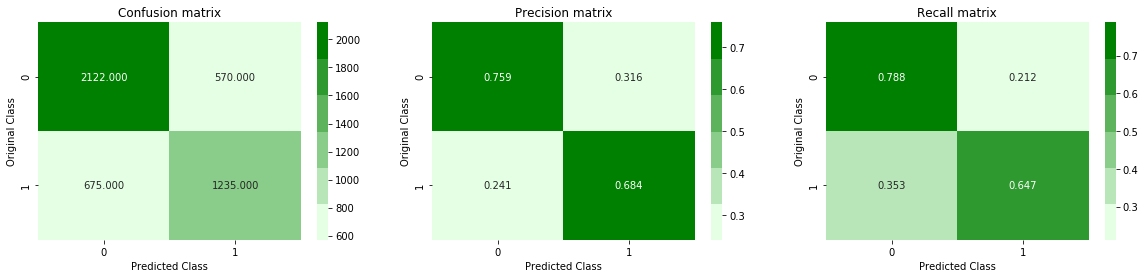

In [39]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_gbdt_bow = best_t

#### TFIDF VECTORIZER

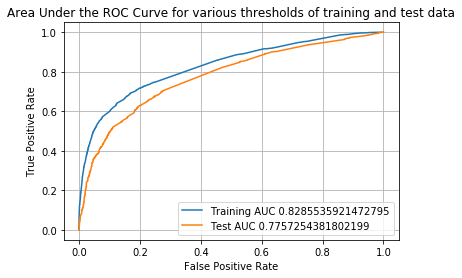

In [40]:
best_n_estimators = 100
best_learning_rate = 0.2

# Fitting the multinomial naive bayes algorithm
best_mod = gbc(n_estimators = best_n_estimators, learning_rate = best_learning_rate)

best_mod.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = best_mod.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = best_mod.predict_proba(preprocessed_te_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_n_est_gbdt_tfidf = best_n_estimators
best_l_rate_gbdt_tfidf = best_learning_rate

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.5754629723199604 for threshold 0.392
Number of misclassified points  27.14037375054324


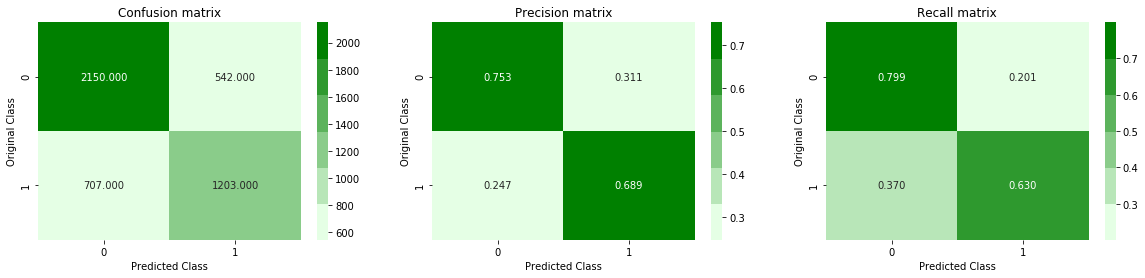

In [41]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_gbdt_tfidf = best_t

### RANDOM FORESTS

#### HYPERPARAMETER TUNING

1) <b>n_estimators</b> which is the number of base learners or the individual decision trees.

2) <b>max_depth</b> which is the maximum depth to which the decision trees should grow.

#### BAG OF WORDS (COUNT VECTORIZER)

The best set of parameters for the Random Forest Classifier on the BOW featurized data are : {'n_estimators': 100, 'max_depth': 100}


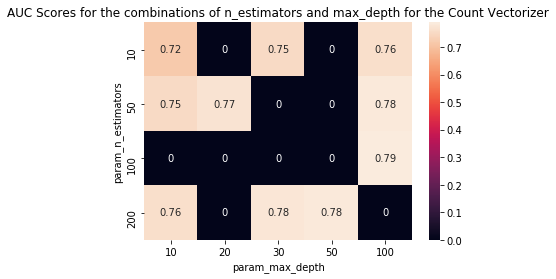

In [42]:
rf_clf = RandomForestClassifier()

params = {'n_estimators':[10,50,100,200], 'max_depth':[10,20,30,50,100]}

clf = RandomizedSearchCV(rf_clf, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_bow, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_max_depth"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_max_depth", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and max_depth for the Count Vectorizer")

print("The best set of parameters for the Random Forest Classifier on the BOW featurized data are : {}".format(clf.best_params_))

#### TFIDF VECTORIZER

The best set of parameters for the Random Forest Classifier on the TFIDF featurized data are : {'n_estimators': 100, 'max_depth': 100}


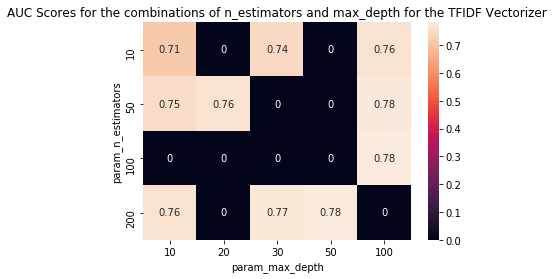

In [43]:
rf_clf = RandomForestClassifier()

params = {'n_estimators':[10,50,100,200], 'max_depth':[10,20,30,50,100]}

clf = RandomizedSearchCV(rf_clf, param_distributions = params, scoring = 'roc_auc', cv=3, return_train_score = True, random_state = 42)
clf.fit(preprocessed_train_tfidf, Y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results.sort_values(by = ["param_n_estimators","param_max_depth"], inplace=True)


train_auc = results["mean_train_score"]
train_std = results["std_train_score"]
cv_auc = results["mean_test_score"]
cv_std = results["std_test_score"]

score_df = pd.pivot_table(data = results, index = "param_n_estimators", columns = "param_max_depth", values = "mean_test_score")

# Removing the nan values from the dataset to avoid any errors during plotting of the auc scores for various combinations
score_df.fillna(0, inplace=True)

sns.heatmap(score_df, annot = True)
plt.title("AUC Scores for the combinations of n_estimators and max_depth for the TFIDF Vectorizer")

print("The best set of parameters for the Random Forest Classifier on the TFIDF featurized data are : {}".format(clf.best_params_))

#### BEST MODEL FITTING

#### BAG OF WORDS (COUNT VECTORIZER)

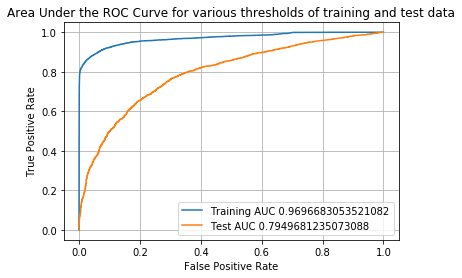

In [44]:
best_n_estimators = 100
best_max_depth = 100

# Fitting the multinomial naive bayes algorithm
best_mod_rf_bow = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, oob_score = True, random_state = 42)

best_mod_rf_bow.fit(preprocessed_train_bow, Y_train)

y_train_pred = best_mod_rf_bow.predict_proba(preprocessed_train_bow)[:,1]
y_test_pred = best_mod_rf_bow.predict_proba(preprocessed_te_bow)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_n_est_rfclf_bow = best_n_estimators
best_max_depth_rfclf_bow = best_max_depth

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.8439071866723373 for threshold 0.358
Number of misclassified points  26.966536288570186


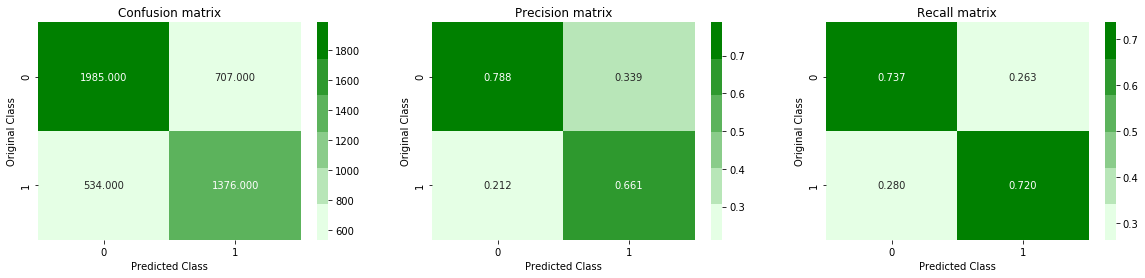

In [45]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_rfclf_bow = best_t

#### TFIDF VECTORIZER

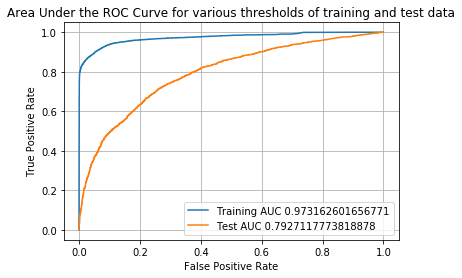

In [46]:
best_n_estimators = 100
best_max_depth = 100

# Fitting the multinomial naive bayes algorithm
best_mod_rf_tfidf = RandomForestClassifier(n_estimators = best_n_estimators, max_depth = best_max_depth, oob_score = True, random_state = 42)

best_mod_rf_tfidf.fit(preprocessed_train_tfidf, Y_train)

y_train_pred = best_mod_rf_tfidf.predict_proba(preprocessed_train_tfidf)[:,1]
y_test_pred = best_mod_rf_tfidf.predict_proba(preprocessed_te_tfidf)[:,1]

train_fpr, train_tpr, tr_thresholds = roc_curve(Y_train, y_train_pred)
test_fpr, test_tpr, te_thresholds = roc_curve(Y_test, y_test_pred)

#plt.figure(figsize = (10,5))
plt.plot(train_fpr, train_tpr, label = "Training AUC " + str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label = "Test AUC " + str(auc(test_fpr, test_tpr)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Area Under the ROC Curve for various thresholds of training and test data")
plt.legend()
plt.grid()
plt.show()

best_n_est_rfclf_tfidf = best_n_estimators
best_max_depth_rfclf_tfidf = best_max_depth

#### TEST DATA PREDICTION AND CONFUSION MATRIX

the maximum value of tpr*(1-fpr) 0.8533655558299608 for threshold 0.344
Number of misclassified points  27.857453281182092


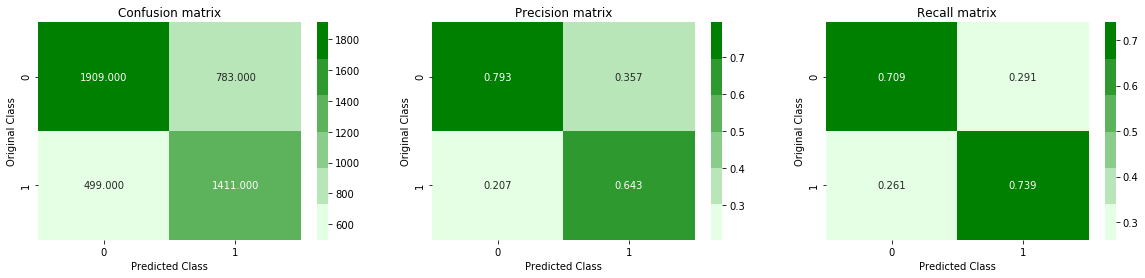

In [47]:
best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)
y_pred = predict_with_best_t(y_test_pred,best_t)
plot_confusion_matrix(Y_test, y_pred)

best_threshold_rfclf_tfidf = best_t

#### MODEL SUMMARY:-

We have used five models to fit on the unigrams BOW and tfidf vectorized data and here are the results summarized in one table as under:-

In [48]:
summary = {'Model':['Naive Bayes','Logistic Regression','Linear SVM','GBDT','Random Forest']*2,
           'Vectorizer':['BOW_Unigrams']*5+['TFIDF_Unigrams']*5, 'Recall_Positive_Class':[0.670,0.706,0.714,0.647,0.720,0.675,0.732,0.712,0.630,0.739]}

fin_summary = pd.DataFrame(summary)

fin_summary

,Model,Vectorizer,Recall_Positive_Class
0,Naive Bayes,BOW_Unigrams,0.670
1,Logistic Regression,BOW_Unigrams,0.706
2,Linear SVM,BOW_Unigrams,0.714
3,GBDT,BOW_Unigrams,0.647
4,Random Forest,BOW_Unigrams,0.720
5,Naive Bayes,TFIDF_Unigrams,0.675
6,Logistic Regression,TFIDF_Unigrams,0.732
7,Linear SVM,TFIDF_Unigrams,0.712
8,GBDT,TFIDF_Unigrams,0.630
9,Random Forest,TFIDF_Unigrams,0.739
